In [ ]:
import yaml
import umap

import scanpy as sc
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from math import floor

from carot.utils import score_transports_and_targets_combinations
from monge.utils import load_config
from cmonge.analysis import get_source_target_transport
from cmonge.trainers.conditional_monge_trainer import ConditionalMongeTrainer
from cmonge.datasets.conditional_loader import ConditionalDataModule

/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
default_colors = {
    "indigo": "#332288",
    "cyan": "#88CCEE",
    "teal": "#44AA99",
    "green": "#117733",
    "olive": "#999933",
    "sand": "#DDCC77",
    "rose": "#CC6677",
    "wine": "#882255",
    "purple": "#AA4499",
    "grey": "#DDDDDD",
}

eval_setting_map = {
    "identity": default_colors["wine"],
    "monge": default_colors["cyan"],
    "cmonge": default_colors["indigo"],
    "within condition": default_colors["green"],
}

geneset_map = {
    "functional": default_colors["olive"],
    "functional+score": default_colors["rose"],
    "HVG": default_colors["teal"],
    "random": default_colors["sand"],
}

subset_map = {
    "CD4": default_colors["teal"],
    "CD8": default_colors["purple"],
}

ot_map = {
    "source": default_colors["cyan"],
    "target": default_colors["sand"],
    "transport": default_colors["rose"],
    "rest": default_colors["grey"]
}


In [1]:
features = "/path/to/genesets/functional_and_score_genes.txt"

logger_path = "/path/to/dummy/logger/notebook_logger.json"
base_config_path = "/path/to/model/configs/cmonge_ood/LN_True_grad_acc_4_cosine/"
base_ckpt_path = "/path/to/model/checkpoints/cmonge_ood/LN_True_grad_acc_4_cosine/"
base_fig_save = "/path/to/figures/transport_UMAPs/cmonge/ood/"

data_path = "/path/to/data/"
car_embedding_path = "/path/to/car/embedding/"
variants_path = "/path/to/variants/"

In [4]:
for subset in ["CD8", "CD4"]:
    adata = sc.read_h5ad(f'{data_path}{subset}.h5ad')
    adata.X = adata.layers['logcounts']
    with open(features, "r") as f:
        genes = f.read().splitlines()
    sel_adata = adata[:, genes]
    umapper = umap.UMAP(random_state=1234)
    Y1 = umapper.fit_transform(sel_adata.X)
    sel_adata.obsm["X_umap"] = Y1

    for car in sel_adata.obs["CAR_Variant"].unique():
        if car in ["NA-NA-NA", "NA-NA-z"]:
            continue
        print(car)
        config_path = f"{base_config_path}/{subset}_esm_XL_tail_dim_FuncScore/NA-NA-NA_{car}/config.yaml"
        config = load_config(config_path)
        config.model.checkpointing_path = f"{base_ckpt_path}/{subset}_esm_XL_tail_dim_FuncScore/NA-NA-NA_{car}/model"
        config.data.file_path = f"{data_path}{subset}.h5ad"
        config.data.features = features
        config.data.drugs_path = f"{variants_path}CAR_variants.txt"
        config.model.embedding.model_dir = car_embedding_path

        batch_size = min(sum(sel_adata.obs["CAR_Variant"]==car), sum(sel_adata.obs["CAR_Variant"]=="NA-NA-NA"))
        batch_size = floor(batch_size * config.data.split[1])
        config.data.batch_size=batch_size
        config.condition.conditions = [car]

        datamodule = ConditionalDataModule(config.data, config.condition, config.ae)
        trainer = ConditionalMongeTrainer.load_checkpoint(
            jobid=1,
            logger_path=logger_path, 
            config=config.model, 
            datamodule=datamodule, 
            ckpt_path=config.model.checkpointing_path
            )
    
        all_expr, all_meta = get_source_target_transport(datamodule=datamodule, 
                                                         trainer=trainer,
                                                         conditions=[car])
    
    
        
        Y2 = umapper.transform(all_expr)
    
        all_meta[["UMAP1", "UMAP2"]] = Y2
    
        sns.scatterplot(x=Y1[:, 0], y=Y1[:, 1], color="grey", s=5, alpha=0.8, linewidth=0)
        sns.scatterplot(data=all_meta, x="UMAP1", y="UMAP2", hue="dtype", s=20, palette=ot_map, alpha=0.95, linewidth=0.15)
        plt.legend([],[], frameon=False)
        plt.tick_params(which="both", axis="both", bottom=False, left=False, labelbottom=False, labelleft=False)
        plt.title(car)
        plt.savefig(f"{base_fig_save}{subset}_{car}_source_transport_target.png", bbox_inches="tight", dpi=300)
        plt.savefig(f"{base_fig_save}{subset}_{car}_source_transport_target.pdf", bbox_inches="tight", dpi=300)
        plt.close()

/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/54/s3nhktxs0tz7w0f6tsj6pltc0000kp/T/ipykernel_23326/1417197449.py:9: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  sel_adata.obsm["X_umap"] = Y1


41BB-41BB-z


2024-09-20 00:02:23.532 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-41BB-z
2024-09-20 00:02:23.979 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:02:24.298 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2024-09-20 00:02:24.298 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:02:24.299 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:02:24.300 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:02:26.632 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
41BB-41BB-z
41BB-CD28-z


2024-09-20 00:02:43.428 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-CD28-z
2024-09-20 00:02:43.940 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:02:43.961 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (581,), valid: (146,), test: (0,).
2024-09-20 00:02:43.962 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:02:43.962 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:02:43.963 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:02:44.053 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
41BB-CD28-z
41BB-CD40-z


2024-09-20 00:02:49.010 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-CD40-z
2024-09-20 00:02:49.426 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:02:49.444 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (377,), valid: (95,), test: (0,).
2024-09-20 00:02:49.444 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:02:49.445 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:02:49.446 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:02:49.532 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
41BB-CD40-z
41BB-CTLA4-z


2024-09-20 00:02:54.495 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-CTLA4-z
2024-09-20 00:02:54.949 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:02:54.970 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (212,), valid: (53,), test: (0,).
2024-09-20 00:02:54.971 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:02:54.971 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:02:54.972 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:02:55.281 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
41BB-CTLA4-z
41BB-IL15RA-z


2024-09-20 00:02:59.923 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-IL15RA-z
2024-09-20 00:03:00.689 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:03:00.705 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (844,), valid: (212,), test: (0,).
2024-09-20 00:03:00.706 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:03:00.707 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:03:00.708 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:03:00.789 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
41BB-IL15RA-z
41BB-NA-z


2024-09-20 00:03:05.727 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-NA-z
2024-09-20 00:03:06.205 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:03:06.228 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (789,), valid: (198,), test: (0,).
2024-09-20 00:03:06.229 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:03:06.229 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:03:06.230 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:03:06.329 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
41BB-NA-z
CD28-41BB-z


2024-09-20 00:03:11.450 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD28-41BB-z
2024-09-20 00:03:11.984 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:03:12.000 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (206,), valid: (52,), test: (0,).
2024-09-20 00:03:12.001 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:03:12.002 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:03:12.002 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:03:12.089 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD28-41BB-z
CD28-CD28-z


2024-09-20 00:03:17.234 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD28-CD28-z
2024-09-20 00:03:17.876 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:03:17.893 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (672,), valid: (168,), test: (0,).
2024-09-20 00:03:17.894 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:03:17.894 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:03:17.895 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:03:17.980 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD28-CD28-z
CD28-CD40-z


2024-09-20 00:03:22.782 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD28-CD40-z
2024-09-20 00:03:23.201 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:03:23.218 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (526,), valid: (132,), test: (0,).
2024-09-20 00:03:23.218 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:03:23.219 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:03:23.220 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:03:23.295 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD28-CD40-z
CD28-CTLA4-z


2024-09-20 00:03:28.318 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD28-CTLA4-z
2024-09-20 00:03:29.056 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:03:29.074 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (350,), valid: (88,), test: (0,).
2024-09-20 00:03:29.074 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:03:29.075 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:03:29.076 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:03:29.153 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD28-CTLA4-z
CD28-IL15RA-z


2024-09-20 00:03:33.659 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD28-IL15RA-z
2024-09-20 00:03:34.387 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:03:34.409 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (719,), valid: (180,), test: (0,).
2024-09-20 00:03:34.410 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:03:34.411 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:03:34.411 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:03:34.488 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD28-IL15RA-z
CD28-NA-z


2024-09-20 00:03:39.804 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD28-NA-z
2024-09-20 00:03:40.857 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:03:40.879 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (883,), valid: (221,), test: (0,).
2024-09-20 00:03:40.880 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:03:40.880 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:03:40.881 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:03:40.982 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD28-NA-z
CD40-41BB-z


2024-09-20 00:03:46.314 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD40-41BB-z
2024-09-20 00:03:47.219 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:03:47.236 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (487,), valid: (122,), test: (0,).
2024-09-20 00:03:47.237 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:03:47.238 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:03:47.239 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:03:47.316 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD40-41BB-z
CD40-CD28-z


2024-09-20 00:03:52.142 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD40-CD28-z
2024-09-20 00:03:52.926 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:03:52.944 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (774,), valid: (194,), test: (0,).
2024-09-20 00:03:52.945 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:03:52.946 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:03:52.946 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:03:53.032 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD40-CD28-z
CD40-CD40-z


2024-09-20 00:03:58.355 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD40-CD40-z
2024-09-20 00:03:58.807 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:03:58.835 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1089,), valid: (273,), test: (0,).
2024-09-20 00:03:58.836 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:03:58.837 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:03:58.838 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:03:58.951 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD40-CD40-z
CD40-CTLA4-z


2024-09-20 00:04:04.223 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD40-CTLA4-z
2024-09-20 00:04:04.746 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:04:04.765 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (559,), valid: (140,), test: (0,).
2024-09-20 00:04:04.766 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:04:04.767 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:04:04.768 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:04:04.949 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD40-CTLA4-z
CD40-IL15RA-z


2024-09-20 00:04:09.881 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD40-IL15RA-z
2024-09-20 00:04:10.819 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:04:10.836 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (552,), valid: (139,), test: (0,).
2024-09-20 00:04:10.837 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:04:10.837 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:04:10.838 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:04:10.923 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD40-IL15RA-z
CD40-NA-z


2024-09-20 00:04:15.626 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD40-NA-z
2024-09-20 00:04:16.081 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:04:16.105 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1004,), valid: (251,), test: (0,).
2024-09-20 00:04:16.106 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:04:16.107 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:04:16.108 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:04:16.195 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD40-NA-z
CTLA4-41BB-z


2024-09-20 00:04:21.897 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CTLA4-41BB-z
2024-09-20 00:04:23.067 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:04:23.084 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (137,), valid: (35,), test: (0,).
2024-09-20 00:04:23.085 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:04:23.086 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:04:23.086 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:04:23.167 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CTLA4-41BB-z
CTLA4-CD28-z


2024-09-20 00:04:27.928 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CTLA4-CD28-z
2024-09-20 00:04:28.816 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:04:28.833 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (202,), valid: (51,), test: (0,).
2024-09-20 00:04:28.834 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:04:28.835 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:04:28.836 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:04:28.922 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CTLA4-CD28-z
CTLA4-CD40-z


2024-09-20 00:04:33.703 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CTLA4-CD40-z
2024-09-20 00:04:34.642 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:04:34.660 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (220,), valid: (56,), test: (0,).
2024-09-20 00:04:34.661 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:04:34.662 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:04:34.663 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:04:34.777 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CTLA4-CD40-z
CTLA4-CTLA4-z


2024-09-20 00:04:39.999 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CTLA4-CTLA4-z
2024-09-20 00:04:41.128 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:04:41.151 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (97,), valid: (25,), test: (0,).
2024-09-20 00:04:41.152 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:04:41.152 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:04:41.153 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:04:41.263 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CTLA4-CTLA4-z
CTLA4-IL15RA-z


2024-09-20 00:04:45.900 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CTLA4-IL15RA-z
2024-09-20 00:04:46.364 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:04:46.382 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (187,), valid: (47,), test: (0,).
2024-09-20 00:04:46.383 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:04:46.384 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:04:46.385 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:04:46.475 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CTLA4-IL15RA-z
CTLA4-NA-z


2024-09-20 00:04:53.180 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CTLA4-NA-z
2024-09-20 00:04:56.663 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:04:56.706 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (201,), valid: (51,), test: (0,).
2024-09-20 00:04:56.706 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:04:56.707 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:04:56.708 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:04:56.873 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CTLA4-NA-z
IL15RA-41BB-z


2024-09-20 00:05:03.546 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for IL15RA-41BB-z
2024-09-20 00:05:03.967 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:05:03.996 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (964,), valid: (242,), test: (0,).
2024-09-20 00:05:03.997 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:05:03.998 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:05:03.999 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:05:04.101 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
IL15RA-41BB-z
IL15RA-CD28-z


2024-09-20 00:05:09.649 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for IL15RA-CD28-z
2024-09-20 00:05:10.036 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:05:10.056 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2024-09-20 00:05:10.057 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:05:10.058 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:05:10.058 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:05:10.138 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
IL15RA-CD28-z
IL15RA-CD40-z


2024-09-20 00:05:14.528 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for IL15RA-CD40-z
2024-09-20 00:05:14.943 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:05:14.964 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1258,), valid: (315,), test: (0,).
2024-09-20 00:05:14.965 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:05:14.966 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:05:14.966 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:05:15.058 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
IL15RA-CD40-z
IL15RA-CTLA4-z


2024-09-20 00:05:20.031 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for IL15RA-CTLA4-z
2024-09-20 00:05:20.431 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:05:20.451 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (936,), valid: (234,), test: (0,).
2024-09-20 00:05:20.451 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:05:20.452 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:05:20.454 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:05:21.165 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
IL15RA-CTLA4-z
IL15RA-IL15RA-z


2024-09-20 00:05:26.054 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for IL15RA-IL15RA-z
2024-09-20 00:05:26.616 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:05:26.635 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (489,), valid: (123,), test: (0,).
2024-09-20 00:05:26.636 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:05:26.637 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:05:26.637 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:05:26.725 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
IL15RA-IL15RA-z
IL15RA-NA-z


2024-09-20 00:05:33.143 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for IL15RA-NA-z
2024-09-20 00:05:33.576 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:05:33.600 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (925,), valid: (232,), test: (0,).
2024-09-20 00:05:33.601 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:05:33.601 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:05:33.602 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:05:33.698 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
IL15RA-NA-z


/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/54/s3nhktxs0tz7w0f6tsj6pltc0000kp/T/ipykernel_23326/1417197449.py:9: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  sel_adata.obsm["X_umap"] = Y1


41BB-41BB-z


2024-09-20 00:06:03.562 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-41BB-z
2024-09-20 00:06:04.005 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:06:04.021 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (746,), valid: (187,), test: (0,).
2024-09-20 00:06:04.022 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:06:04.023 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:06:04.024 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:06:04.103 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
41BB-41BB-z
41BB-CD28-z


2024-09-20 00:06:12.171 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-CD28-z
2024-09-20 00:06:12.659 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:06:12.677 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1085,), valid: (272,), test: (0,).
2024-09-20 00:06:12.678 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:06:12.678 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:06:12.679 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:06:12.760 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
41BB-CD28-z
41BB-CD40-z


2024-09-20 00:06:17.305 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-CD40-z
2024-09-20 00:06:17.820 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:06:17.837 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (776,), valid: (195,), test: (0,).
2024-09-20 00:06:17.838 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:06:17.839 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:06:17.839 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:06:17.923 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
41BB-CD40-z
41BB-CTLA4-z


2024-09-20 00:06:22.537 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-CTLA4-z
2024-09-20 00:06:23.103 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:06:23.124 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (248,), valid: (63,), test: (0,).
2024-09-20 00:06:23.125 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:06:23.125 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:06:23.126 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:06:23.228 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
41BB-CTLA4-z
41BB-IL15RA-z


2024-09-20 00:06:28.071 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-IL15RA-z
2024-09-20 00:06:28.655 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:06:28.681 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (840,), valid: (211,), test: (0,).
2024-09-20 00:06:28.682 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:06:28.683 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:06:28.684 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:06:28.778 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
41BB-IL15RA-z
41BB-NA-z


2024-09-20 00:06:33.781 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-NA-z
2024-09-20 00:06:34.276 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:06:34.299 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (765,), valid: (192,), test: (0,).
2024-09-20 00:06:34.300 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:06:34.300 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:06:34.301 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:06:34.384 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
41BB-NA-z
CD28-41BB-z


2024-09-20 00:06:38.918 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD28-41BB-z
2024-09-20 00:06:39.415 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:06:39.437 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (172,), valid: (43,), test: (0,).
2024-09-20 00:06:39.437 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:06:39.438 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:06:39.439 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:06:39.523 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD28-41BB-z
CD28-CD28-z


2024-09-20 00:06:44.683 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD28-CD28-z
2024-09-20 00:06:45.137 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:06:45.158 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (833,), valid: (209,), test: (0,).
2024-09-20 00:06:45.158 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:06:45.160 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:06:45.160 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:06:45.242 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD28-CD28-z
CD28-CD40-z


2024-09-20 00:06:49.798 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD28-CD40-z
2024-09-20 00:06:50.311 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:06:50.336 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (818,), valid: (205,), test: (0,).
2024-09-20 00:06:50.337 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:06:50.337 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:06:50.338 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:06:50.420 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD28-CD40-z
CD28-CTLA4-z


2024-09-20 00:06:54.950 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD28-CTLA4-z
2024-09-20 00:06:55.449 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:06:55.470 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (214,), valid: (54,), test: (0,).
2024-09-20 00:06:55.470 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:06:55.471 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:06:55.471 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:06:55.567 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD28-CTLA4-z
CD28-IL15RA-z


2024-09-20 00:07:00.001 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD28-IL15RA-z
2024-09-20 00:07:00.494 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:07:00.512 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1153,), valid: (289,), test: (0,).
2024-09-20 00:07:00.512 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:07:00.513 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:07:00.514 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:07:00.601 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD28-IL15RA-z
CD28-NA-z


2024-09-20 00:07:05.787 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD28-NA-z
2024-09-20 00:07:06.225 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:07:06.248 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1145,), valid: (287,), test: (0,).
2024-09-20 00:07:06.249 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:07:06.250 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:07:06.251 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:07:06.341 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD28-NA-z
CD40-41BB-z


2024-09-20 00:07:11.730 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD40-41BB-z
2024-09-20 00:07:12.179 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:07:12.196 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (556,), valid: (140,), test: (0,).
2024-09-20 00:07:12.197 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:07:12.198 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:07:12.198 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:07:12.286 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD40-41BB-z
CD40-CD28-z


2024-09-20 00:07:17.107 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD40-CD28-z
2024-09-20 00:07:17.747 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:07:17.763 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (590,), valid: (148,), test: (0,).
2024-09-20 00:07:17.764 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:07:17.764 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:07:17.765 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:07:17.843 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD40-CD28-z
CD40-CD40-z


2024-09-20 00:07:23.204 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD40-CD40-z
2024-09-20 00:07:23.695 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:07:23.713 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (542,), valid: (136,), test: (0,).
2024-09-20 00:07:23.714 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:07:23.715 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:07:23.716 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:07:23.812 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD40-CD40-z
CD40-CTLA4-z


2024-09-20 00:07:29.079 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD40-CTLA4-z
2024-09-20 00:07:29.560 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:07:29.577 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (259,), valid: (65,), test: (0,).
2024-09-20 00:07:29.577 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:07:29.578 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:07:29.579 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:07:29.660 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD40-CTLA4-z
CD40-IL15RA-z


2024-09-20 00:07:34.977 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD40-IL15RA-z
2024-09-20 00:07:35.658 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:07:35.676 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (645,), valid: (162,), test: (0,).
2024-09-20 00:07:35.677 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:07:35.677 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:07:35.678 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:07:35.774 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD40-IL15RA-z
CD40-NA-z


2024-09-20 00:07:41.208 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD40-NA-z
2024-09-20 00:07:42.242 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:07:42.258 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (794,), valid: (199,), test: (0,).
2024-09-20 00:07:42.259 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:07:42.259 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:07:42.260 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:07:42.346 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD40-NA-z
CTLA4-41BB-z


2024-09-20 00:07:46.702 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CTLA4-41BB-z
2024-09-20 00:07:47.180 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:07:47.200 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (188,), valid: (48,), test: (0,).
2024-09-20 00:07:47.201 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:07:47.201 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:07:47.202 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:07:47.296 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CTLA4-41BB-z
CTLA4-CD28-z


2024-09-20 00:07:52.524 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CTLA4-CD28-z
2024-09-20 00:07:53.744 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:07:53.760 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (452,), valid: (113,), test: (0,).
2024-09-20 00:07:53.761 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:07:53.761 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:07:53.762 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:07:53.843 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CTLA4-CD28-z
CTLA4-CD40-z


2024-09-20 00:07:59.117 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CTLA4-CD40-z
2024-09-20 00:07:59.945 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:07:59.961 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (162,), valid: (41,), test: (0,).
2024-09-20 00:07:59.962 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:07:59.962 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:07:59.963 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:08:00.047 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CTLA4-CD40-z
CTLA4-CTLA4-z


2024-09-20 00:08:04.897 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CTLA4-CTLA4-z
2024-09-20 00:08:05.385 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:08:05.403 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (222,), valid: (56,), test: (0,).
2024-09-20 00:08:05.403 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:08:05.404 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:08:05.405 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:08:05.486 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CTLA4-CTLA4-z
CTLA4-IL15RA-z


2024-09-20 00:08:09.854 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CTLA4-IL15RA-z
2024-09-20 00:08:10.686 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:08:10.704 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (152,), valid: (38,), test: (0,).
2024-09-20 00:08:10.704 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:08:10.705 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:08:10.706 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:08:10.798 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CTLA4-IL15RA-z
CTLA4-NA-z


2024-09-20 00:08:16.658 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CTLA4-NA-z
2024-09-20 00:08:17.926 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:08:17.943 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (171,), valid: (43,), test: (0,).
2024-09-20 00:08:17.944 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:08:17.944 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:08:17.945 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:08:18.037 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CTLA4-NA-z
IL15RA-41BB-z


2024-09-20 00:08:22.753 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for IL15RA-41BB-z
2024-09-20 00:08:23.237 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:08:23.255 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (894,), valid: (224,), test: (0,).
2024-09-20 00:08:23.255 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:08:23.256 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:08:23.256 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:08:23.337 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
IL15RA-41BB-z
IL15RA-CD28-z


2024-09-20 00:08:27.724 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for IL15RA-CD28-z
2024-09-20 00:08:28.709 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:08:28.726 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (991,), valid: (248,), test: (0,).
2024-09-20 00:08:28.727 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:08:28.728 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:08:28.728 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:08:28.811 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
IL15RA-CD28-z
IL15RA-CD40-z


2024-09-20 00:08:34.126 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for IL15RA-CD40-z
2024-09-20 00:08:35.057 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:08:35.077 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (790,), valid: (198,), test: (0,).
2024-09-20 00:08:35.078 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:08:35.078 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:08:35.079 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:08:35.171 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
IL15RA-CD40-z
IL15RA-CTLA4-z


2024-09-20 00:08:39.767 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for IL15RA-CTLA4-z
2024-09-20 00:08:40.309 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:08:40.327 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (364,), valid: (92,), test: (0,).
2024-09-20 00:08:40.327 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:08:40.328 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:08:40.329 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:08:40.420 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
IL15RA-CTLA4-z
IL15RA-IL15RA-z


2024-09-20 00:08:45.924 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for IL15RA-IL15RA-z
2024-09-20 00:08:46.432 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:08:46.451 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1110,), valid: (278,), test: (0,).
2024-09-20 00:08:46.452 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:08:46.452 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:08:46.453 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:08:46.543 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
IL15RA-IL15RA-z
IL15RA-NA-z


2024-09-20 00:08:50.615 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for IL15RA-NA-z
2024-09-20 00:08:51.045 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:08:51.064 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1123,), valid: (281,), test: (0,).
2024-09-20 00:08:51.064 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:08:51.065 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:08:51.066 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:08:51.147 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
IL15RA-NA-z


/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/54/s3nhktxs0tz7w0f6tsj6pltc0000kp/T/ipykernel_26731/1327753497.py:9: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  sel_adata.obsm["X_umap"] = Y1


41BB-41BB-z


2024-09-20 00:11:10.742 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-41BB-z
2024-09-20 00:11:11.121 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:11:11.538 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2024-09-20 00:11:11.539 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:11:11.539 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:11:11.540 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:11:13.704 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
41BB-41BB-z
41BB-CD28-z


2024-09-20 00:11:28.322 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-CD28-z
2024-09-20 00:11:28.697 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:11:28.718 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (581,), valid: (146,), test: (0,).
2024-09-20 00:11:28.719 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:11:28.719 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:11:28.720 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:11:28.802 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
41BB-CD28-z
41BB-CD40-z


2024-09-20 00:11:31.661 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-CD40-z
2024-09-20 00:11:32.043 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:11:32.062 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (377,), valid: (95,), test: (0,).
2024-09-20 00:11:32.063 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:11:32.063 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:11:32.064 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:11:32.145 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
41BB-CD40-z
41BB-CTLA4-z


2024-09-20 00:11:35.141 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-CTLA4-z
2024-09-20 00:11:35.528 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:11:35.546 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (212,), valid: (53,), test: (0,).
2024-09-20 00:11:35.547 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:11:35.547 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:11:35.548 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:11:35.633 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
41BB-CTLA4-z
41BB-IL15RA-z


2024-09-20 00:11:38.285 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-IL15RA-z
2024-09-20 00:11:38.668 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:11:38.688 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (844,), valid: (212,), test: (0,).
2024-09-20 00:11:38.689 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:11:38.689 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:11:38.690 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:11:38.771 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
41BB-IL15RA-z
41BB-NA-z


2024-09-20 00:11:41.750 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-NA-z
2024-09-20 00:11:42.144 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:11:42.163 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (789,), valid: (198,), test: (0,).
2024-09-20 00:11:42.164 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:11:42.164 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:11:42.165 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:11:42.248 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
41BB-NA-z
CD28-41BB-z


2024-09-20 00:11:45.194 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD28-41BB-z
2024-09-20 00:11:45.594 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:11:45.613 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (206,), valid: (52,), test: (0,).
2024-09-20 00:11:45.613 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:11:45.614 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:11:45.615 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:11:45.719 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD28-41BB-z
CD28-CD28-z


2024-09-20 00:11:48.705 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD28-CD28-z
2024-09-20 00:11:49.107 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:11:49.127 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (672,), valid: (168,), test: (0,).
2024-09-20 00:11:49.127 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:11:49.128 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:11:49.129 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:11:49.206 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD28-CD28-z
CD28-CD40-z


2024-09-20 00:11:52.195 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD28-CD40-z
2024-09-20 00:11:52.578 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:11:52.597 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (526,), valid: (132,), test: (0,).
2024-09-20 00:11:52.598 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:11:52.598 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:11:52.599 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:11:52.682 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD28-CD40-z
CD28-CTLA4-z


2024-09-20 00:11:55.557 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD28-CTLA4-z
2024-09-20 00:11:55.948 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:11:55.967 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (350,), valid: (88,), test: (0,).
2024-09-20 00:11:55.968 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:11:55.969 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:11:55.970 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:11:56.051 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD28-CTLA4-z
CD28-IL15RA-z


2024-09-20 00:11:58.825 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD28-IL15RA-z
2024-09-20 00:11:59.211 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:11:59.231 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (719,), valid: (180,), test: (0,).
2024-09-20 00:11:59.231 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:11:59.232 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:11:59.233 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:11:59.311 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD28-IL15RA-z
CD28-NA-z


2024-09-20 00:12:02.618 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD28-NA-z
2024-09-20 00:12:03.008 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:12:03.027 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (883,), valid: (221,), test: (0,).
2024-09-20 00:12:03.028 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:12:03.028 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:12:03.029 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:12:03.114 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD28-NA-z
CD40-41BB-z


2024-09-20 00:12:06.735 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD40-41BB-z
2024-09-20 00:12:07.194 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:12:07.217 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (487,), valid: (122,), test: (0,).
2024-09-20 00:12:07.218 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:12:07.218 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:12:07.219 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:12:07.311 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD40-41BB-z
CD40-CD28-z


2024-09-20 00:12:11.036 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD40-CD28-z
2024-09-20 00:12:11.481 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:12:11.504 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (774,), valid: (194,), test: (0,).
2024-09-20 00:12:11.505 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:12:11.506 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:12:11.507 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:12:11.584 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD40-CD28-z
CD40-CD40-z


2024-09-20 00:12:15.521 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD40-CD40-z
2024-09-20 00:12:15.970 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:12:15.993 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1089,), valid: (273,), test: (0,).
2024-09-20 00:12:15.993 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:12:15.994 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:12:15.994 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:12:16.069 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD40-CD40-z
CD40-CTLA4-z


2024-09-20 00:12:20.121 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD40-CTLA4-z
2024-09-20 00:12:20.593 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:12:20.617 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (559,), valid: (140,), test: (0,).
2024-09-20 00:12:20.618 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:12:20.619 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:12:20.619 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:12:20.732 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD40-CTLA4-z
CD40-IL15RA-z


2024-09-20 00:12:24.586 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD40-IL15RA-z
2024-09-20 00:12:25.055 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:12:25.078 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (552,), valid: (139,), test: (0,).
2024-09-20 00:12:25.079 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:12:25.079 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:12:25.080 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:12:25.158 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD40-IL15RA-z
CD40-NA-z


2024-09-20 00:12:29.094 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD40-NA-z
2024-09-20 00:12:29.549 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:12:29.571 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1004,), valid: (251,), test: (0,).
2024-09-20 00:12:29.572 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:12:29.572 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:12:29.573 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:12:29.655 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD40-NA-z
CTLA4-41BB-z


2024-09-20 00:12:33.356 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CTLA4-41BB-z
2024-09-20 00:12:33.789 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:12:33.808 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (137,), valid: (35,), test: (0,).
2024-09-20 00:12:33.811 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:12:33.812 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:12:33.812 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:12:33.906 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CTLA4-41BB-z
CTLA4-CD28-z


2024-09-20 00:12:37.307 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CTLA4-CD28-z
2024-09-20 00:12:37.756 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:12:37.774 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (202,), valid: (51,), test: (0,).
2024-09-20 00:12:37.774 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:12:37.775 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:12:37.776 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:12:37.859 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CTLA4-CD28-z
CTLA4-CD40-z


2024-09-20 00:12:41.665 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CTLA4-CD40-z
2024-09-20 00:12:42.138 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:12:42.158 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (220,), valid: (56,), test: (0,).
2024-09-20 00:12:42.159 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:12:42.160 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:12:42.160 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:12:42.243 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CTLA4-CD40-z
CTLA4-CTLA4-z


2024-09-20 00:12:45.790 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CTLA4-CTLA4-z
2024-09-20 00:12:46.254 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:12:46.278 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (97,), valid: (25,), test: (0,).
2024-09-20 00:12:46.280 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:12:46.281 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:12:46.281 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:12:46.373 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CTLA4-CTLA4-z
CTLA4-IL15RA-z


2024-09-20 00:12:49.767 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CTLA4-IL15RA-z
2024-09-20 00:12:50.243 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:12:50.263 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (187,), valid: (47,), test: (0,).
2024-09-20 00:12:50.263 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:12:50.264 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:12:50.265 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:12:50.355 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CTLA4-IL15RA-z
CTLA4-NA-z


2024-09-20 00:12:53.591 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CTLA4-NA-z
2024-09-20 00:12:54.060 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:12:54.083 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (201,), valid: (51,), test: (0,).
2024-09-20 00:12:54.084 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:12:54.085 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:12:54.085 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:12:54.172 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CTLA4-NA-z
IL15RA-41BB-z


2024-09-20 00:12:56.837 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for IL15RA-41BB-z
2024-09-20 00:12:57.468 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:12:57.486 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (964,), valid: (242,), test: (0,).
2024-09-20 00:12:57.486 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:12:57.487 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:12:57.487 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:12:57.566 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
IL15RA-41BB-z
IL15RA-CD28-z


2024-09-20 00:13:01.584 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for IL15RA-CD28-z
2024-09-20 00:13:02.018 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:13:02.036 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2024-09-20 00:13:02.037 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:13:02.037 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:13:02.038 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:13:02.118 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
IL15RA-CD28-z
IL15RA-CD40-z


2024-09-20 00:13:05.435 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for IL15RA-CD40-z
2024-09-20 00:13:06.104 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:13:06.123 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1258,), valid: (315,), test: (0,).
2024-09-20 00:13:06.124 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:13:06.125 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:13:06.126 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:13:06.201 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
IL15RA-CD40-z
IL15RA-CTLA4-z


2024-09-20 00:13:10.518 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for IL15RA-CTLA4-z
2024-09-20 00:13:10.963 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:13:10.986 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (936,), valid: (234,), test: (0,).
2024-09-20 00:13:10.987 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:13:10.987 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:13:10.988 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:13:11.075 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
IL15RA-CTLA4-z
IL15RA-IL15RA-z


2024-09-20 00:13:14.778 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for IL15RA-IL15RA-z
2024-09-20 00:13:15.206 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:13:15.225 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (489,), valid: (123,), test: (0,).
2024-09-20 00:13:15.225 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:13:15.226 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:13:15.227 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:13:15.305 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
IL15RA-IL15RA-z
IL15RA-NA-z


2024-09-20 00:13:19.307 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for IL15RA-NA-z
2024-09-20 00:13:20.144 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:13:20.164 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (925,), valid: (232,), test: (0,).
2024-09-20 00:13:20.164 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-09-20 00:13:20.165 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:13:20.166 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:13:20.251 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
IL15RA-NA-z


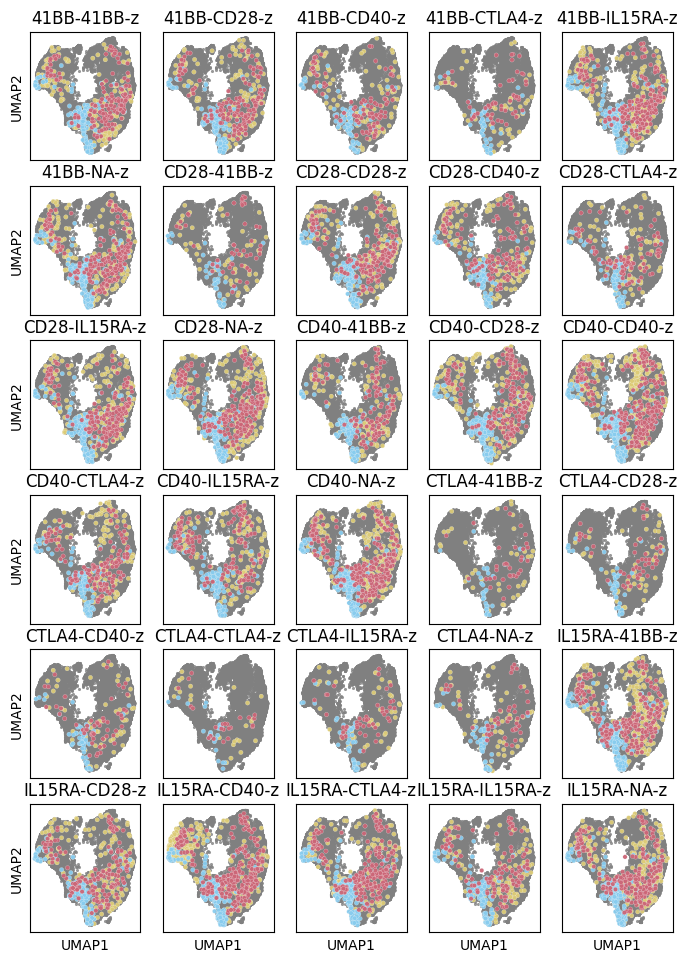

/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/54/s3nhktxs0tz7w0f6tsj6pltc0000kp/T/ipykernel_26731/1327753497.py:9: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  sel_adata.obsm["X_umap"] = Y1


41BB-41BB-z


2024-09-20 00:14:14.411 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-41BB-z
2024-09-20 00:14:14.900 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:14:14.924 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (746,), valid: (187,), test: (0,).
2024-09-20 00:14:14.925 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:14:14.925 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:14:14.926 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:14:15.012 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
41BB-41BB-z
41BB-CD28-z


2024-09-20 00:14:21.912 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-CD28-z
2024-09-20 00:14:23.373 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:14:23.393 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1085,), valid: (272,), test: (0,).
2024-09-20 00:14:23.395 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:14:23.395 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:14:23.396 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:14:23.495 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
41BB-CD28-z
41BB-CD40-z


2024-09-20 00:14:27.026 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-CD40-z
2024-09-20 00:14:28.281 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:14:28.299 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (776,), valid: (195,), test: (0,).
2024-09-20 00:14:28.300 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:14:28.300 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:14:28.301 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:14:28.397 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
41BB-CD40-z
41BB-CTLA4-z


2024-09-20 00:14:31.197 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-CTLA4-z
2024-09-20 00:14:31.693 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:14:31.713 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (248,), valid: (63,), test: (0,).
2024-09-20 00:14:31.715 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:14:31.716 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:14:31.717 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:14:31.800 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
41BB-CTLA4-z
41BB-IL15RA-z


2024-09-20 00:14:35.428 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-IL15RA-z
2024-09-20 00:14:35.968 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:14:35.988 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (840,), valid: (211,), test: (0,).
2024-09-20 00:14:35.988 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:14:35.989 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:14:35.990 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:14:36.066 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
41BB-IL15RA-z
41BB-NA-z


2024-09-20 00:14:39.551 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-NA-z
2024-09-20 00:14:40.645 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:14:40.665 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (765,), valid: (192,), test: (0,).
2024-09-20 00:14:40.666 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:14:40.667 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:14:40.667 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:14:40.757 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
41BB-NA-z
CD28-41BB-z


2024-09-20 00:14:44.605 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD28-41BB-z
2024-09-20 00:14:45.313 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:14:45.333 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (172,), valid: (43,), test: (0,).
2024-09-20 00:14:45.334 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:14:45.334 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:14:45.335 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:14:45.416 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD28-41BB-z
CD28-CD28-z


2024-09-20 00:14:49.133 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD28-CD28-z
2024-09-20 00:14:50.494 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:14:50.521 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (833,), valid: (209,), test: (0,).
2024-09-20 00:14:50.522 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:14:50.523 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:14:50.524 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:14:50.642 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD28-CD28-z
CD28-CD40-z


2024-09-20 00:14:53.097 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD28-CD40-z
2024-09-20 00:14:53.509 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:14:53.528 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (818,), valid: (205,), test: (0,).
2024-09-20 00:14:53.529 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:14:53.529 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:14:53.530 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:14:53.608 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD28-CD40-z
CD28-CTLA4-z


2024-09-20 00:14:55.985 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD28-CTLA4-z
2024-09-20 00:14:56.382 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:14:56.400 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (214,), valid: (54,), test: (0,).
2024-09-20 00:14:56.401 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:14:56.401 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:14:56.402 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:14:56.487 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD28-CTLA4-z
CD28-IL15RA-z


2024-09-20 00:14:58.758 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD28-IL15RA-z
2024-09-20 00:14:59.178 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:14:59.195 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1153,), valid: (289,), test: (0,).
2024-09-20 00:14:59.196 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:14:59.196 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:14:59.197 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:14:59.273 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD28-IL15RA-z
CD28-NA-z


2024-09-20 00:15:01.655 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD28-NA-z
2024-09-20 00:15:02.052 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:15:02.071 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1145,), valid: (287,), test: (0,).
2024-09-20 00:15:02.072 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:15:02.072 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:15:02.073 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:15:02.163 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD28-NA-z
CD40-41BB-z


2024-09-20 00:15:04.998 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD40-41BB-z
2024-09-20 00:15:05.426 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:15:05.443 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (556,), valid: (140,), test: (0,).
2024-09-20 00:15:05.443 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:15:05.444 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:15:05.445 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:15:05.533 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD40-41BB-z
CD40-CD28-z


2024-09-20 00:15:07.980 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD40-CD28-z
2024-09-20 00:15:08.385 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:15:08.404 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (590,), valid: (148,), test: (0,).
2024-09-20 00:15:08.405 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:15:08.405 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:15:08.406 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:15:08.493 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD40-CD28-z
CD40-CD40-z


2024-09-20 00:15:11.750 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD40-CD40-z
2024-09-20 00:15:12.143 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:15:12.160 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (542,), valid: (136,), test: (0,).
2024-09-20 00:15:12.161 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:15:12.162 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:15:12.162 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:15:12.249 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD40-CD40-z
CD40-CTLA4-z


2024-09-20 00:15:16.160 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD40-CTLA4-z
2024-09-20 00:15:16.633 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:15:16.657 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (259,), valid: (65,), test: (0,).
2024-09-20 00:15:16.658 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:15:16.659 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:15:16.660 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:15:16.740 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD40-CTLA4-z
CD40-IL15RA-z


2024-09-20 00:15:20.912 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD40-IL15RA-z
2024-09-20 00:15:21.407 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:15:21.428 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (645,), valid: (162,), test: (0,).
2024-09-20 00:15:21.429 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:15:21.429 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:15:21.430 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:15:21.513 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD40-IL15RA-z
CD40-NA-z


2024-09-20 00:15:24.897 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CD40-NA-z
2024-09-20 00:15:25.396 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:15:25.416 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (794,), valid: (199,), test: (0,).
2024-09-20 00:15:25.417 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:15:25.417 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:15:25.418 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:15:25.502 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CD40-NA-z
CTLA4-41BB-z


2024-09-20 00:15:29.115 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CTLA4-41BB-z
2024-09-20 00:15:29.577 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:15:29.598 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (188,), valid: (48,), test: (0,).
2024-09-20 00:15:29.598 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:15:29.599 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:15:29.599 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:15:29.680 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CTLA4-41BB-z
CTLA4-CD28-z


2024-09-20 00:15:33.616 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CTLA4-CD28-z
2024-09-20 00:15:34.113 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:15:34.136 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (452,), valid: (113,), test: (0,).
2024-09-20 00:15:34.138 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:15:34.139 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:15:34.139 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:15:34.223 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CTLA4-CD28-z
CTLA4-CD40-z


2024-09-20 00:15:38.246 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CTLA4-CD40-z
2024-09-20 00:15:38.721 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:15:38.738 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (162,), valid: (41,), test: (0,).
2024-09-20 00:15:38.738 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:15:38.739 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:15:38.740 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:15:38.815 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CTLA4-CD40-z
CTLA4-CTLA4-z


2024-09-20 00:15:42.627 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CTLA4-CTLA4-z
2024-09-20 00:15:43.099 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:15:43.118 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (222,), valid: (56,), test: (0,).
2024-09-20 00:15:43.119 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:15:43.120 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:15:43.120 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:15:43.208 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CTLA4-CTLA4-z
CTLA4-IL15RA-z


2024-09-20 00:15:46.017 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CTLA4-IL15RA-z
2024-09-20 00:15:46.480 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:15:46.496 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (152,), valid: (38,), test: (0,).
2024-09-20 00:15:46.497 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:15:46.497 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:15:46.498 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:15:46.590 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CTLA4-IL15RA-z
CTLA4-NA-z


2024-09-20 00:15:50.153 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for CTLA4-NA-z
2024-09-20 00:15:50.655 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:15:50.675 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (171,), valid: (43,), test: (0,).
2024-09-20 00:15:50.676 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:15:50.676 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:15:50.677 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:15:50.757 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
CTLA4-NA-z
IL15RA-41BB-z


2024-09-20 00:15:55.093 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for IL15RA-41BB-z
2024-09-20 00:15:55.565 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:15:55.582 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (894,), valid: (224,), test: (0,).
2024-09-20 00:15:55.583 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:15:55.583 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:15:55.584 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:15:55.717 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
IL15RA-41BB-z
IL15RA-CD28-z


2024-09-20 00:15:58.983 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for IL15RA-CD28-z
2024-09-20 00:15:59.444 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:15:59.463 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (991,), valid: (248,), test: (0,).
2024-09-20 00:15:59.464 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:15:59.465 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:15:59.466 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:15:59.551 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
IL15RA-CD28-z
IL15RA-CD40-z


2024-09-20 00:16:02.718 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for IL15RA-CD40-z
2024-09-20 00:16:03.186 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:16:03.212 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (790,), valid: (198,), test: (0,).
2024-09-20 00:16:03.213 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:16:03.213 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:16:03.214 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:16:03.304 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
IL15RA-CD40-z
IL15RA-CTLA4-z


2024-09-20 00:16:06.261 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for IL15RA-CTLA4-z
2024-09-20 00:16:06.709 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:16:06.729 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (364,), valid: (92,), test: (0,).
2024-09-20 00:16:06.730 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:16:06.731 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:16:06.732 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:16:06.837 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
IL15RA-CTLA4-z
IL15RA-IL15RA-z


2024-09-20 00:16:10.491 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for IL15RA-IL15RA-z
2024-09-20 00:16:10.951 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:16:10.969 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1110,), valid: (278,), test: (0,).
2024-09-20 00:16:10.970 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:16:10.970 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:16:10.971 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:16:11.053 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
IL15RA-IL15RA-z
IL15RA-NA-z


2024-09-20 00:16:14.283 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for IL15RA-NA-z
2024-09-20 00:16:15.008 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-20 00:16:15.028 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (1123,), valid: (281,), test: (0,).
2024-09-20 00:16:15.028 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-20 00:16:15.029 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-20 00:16:15.029 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-20 00:16:15.108 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint


Evaluating on validation set
IL15RA-NA-z


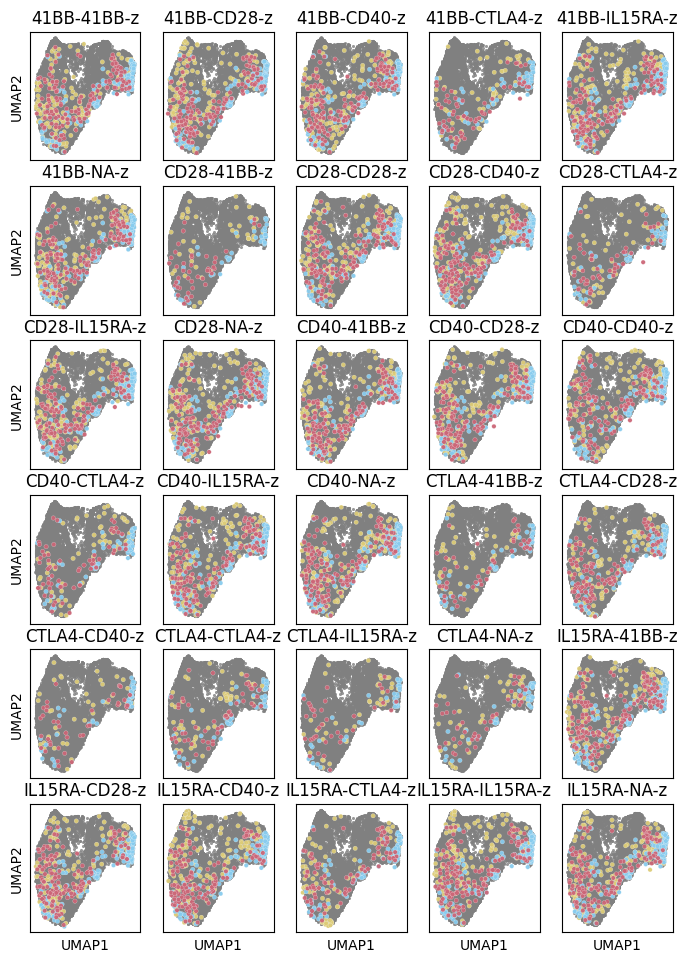

In [4]:
for subset in ["CD8", "CD4"]:
    adata = sc.read_h5ad(f'{data_path}{subset}.h5ad')
    adata.X = adata.layers['logcounts']
    with open(features, "r") as f:
        genes = f.read().splitlines()
    sel_adata = adata[:, genes]
    umapper = umap.UMAP(random_state=1234)
    Y1 = umapper.fit_transform(sel_adata.X)
    sel_adata.obsm["X_umap"] = Y1

    fig, axes = plt.subplots(nrows=6,ncols=5, sharex=True, sharey=True, figsize=(8.3, 11.7))
    flat_axes = axes.flatten()
    i =0

    for car in sel_adata.obs["CAR_Variant"].unique():
        if car in ["NA-NA-NA", "NA-NA-z"]:
            continue
        print(car)
        config_path = f"{base_config_path}/{subset}_esm_XL_tail_dim_FuncScore/NA-NA-NA_{car}/config.yaml"
        config = load_config(config_path)
        config.model.checkpointing_path = f"{base_ckpt_path}/{subset}_esm_XL_tail_dim_FuncScore/NA-NA-NA_{car}/model"
        config.data.file_path = f"{data_path}{subset}.h5ad"
        config.data.features = features
        config.data.drugs_path = f"{variants_path}CAR_variants.txt"
        config.model.embedding.model_dir = car_embedding_path

        batch_size = min(sum(sel_adata.obs["CAR_Variant"]==car), sum(sel_adata.obs["CAR_Variant"]=="NA-NA-NA"))
        batch_size = floor(batch_size * config.data.split[1])
        config.data.batch_size=batch_size
        config.condition.conditions = [car]

        datamodule = ConditionalDataModule(config.data, config.condition, config.ae)
        trainer = ConditionalMongeTrainer.load_checkpoint(
            jobid=1,
            logger_path=logger_path, 
            config=config.model, 
            datamodule=datamodule, 
            ckpt_path=config.model.checkpointing_path
            )
    
        all_expr, all_meta = get_source_target_transport(datamodule=datamodule, 
                                                         trainer=trainer,
                                                         conditions=[car])
    
    
        
        Y2 = umapper.transform(all_expr)

        all_meta[["UMAP1", "UMAP2"]] = Y2

        sns.scatterplot(x=Y1[:, 0], y=Y1[:, 1], color="grey", s=5, ax=flat_axes[i], alpha=0.8, linewidth=0)
        sns.scatterplot(data=all_meta, x="UMAP1", y="UMAP2", hue="dtype", s=10, palette=ot_map, ax=flat_axes[i], alpha=0.95, linewidth=0.15)
        flat_axes[i].get_legend().remove()
        flat_axes[i].tick_params(which="both", axis="both", bottom=False, left=False, labelbottom=False, labelleft=False)
        flat_axes[i].set_title(car)
        i+=1
    plt.savefig(f"{base_fig_save}{subset}_all.png", bbox_inches="tight", dpi=300)
    plt.savefig(f"{base_fig_save}{subset}_all.pdf", bbox_inches="tight", dpi=300)
    plt.show()